In [1]:
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### Parameters

All parameters are from https://arxiv.org/pdf/1511.06434.pdf

In [2]:
# Root directory for dataset
dataroot = "data/nice_six/"

num_epochs = 30

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
num_channel = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 100

# Size of feature maps in generator
gen_dim = 64

# Size of feature maps in discriminator
dis_dim = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

### Load dataset

Device:  cuda:0
Min (should be -1):  tensor(-1.)
Max (should be 1):  tensor(1.)
Shape: (batch, C, H, W)   torch.Size([128, 3, 64, 64])


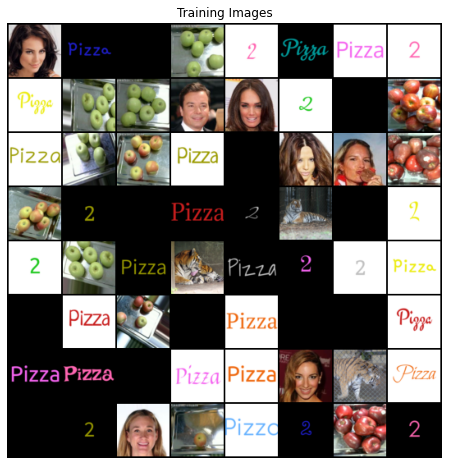

In [3]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #make sure we only accept this size
                               transforms.Resize(image_size),
                               #focus the image
                               transforms.CenterCrop(image_size),
                               #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                               transforms.ToTensor(),  
                               #[mean for three channels], #[std for three channels] this will scale our data to [-1, 1] which will fits to tanh output of the generator
                               #tanh is found by the paper to be good, thus we have to scale our input image as well
                               #min-value:  0 - 0.5 / 0.5 = -1,  max-value: 1 - 0.5 / 0.5 = 1
                               transforms.Normalize([0.5 for _ in range(num_channel)], [0.5 for _ in range(num_channel)]), 
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

# Plot some training images
real_batch = next(iter(dataloader))

print("Min (should be -1): ", real_batch[0].min())
print("Max (should be 1): ", real_batch[0].max())
print("Shape: (batch, C, H, W)  ", real_batch[0].shape)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The ``weights_init`` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(model):
    for m in model.modules(): #loop all layers in that model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Generator

Follow the paper

In [5]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #Input: batch x z_dim x 1 x 1 (see definition of noise in below code)
            self._block(z_dim, gen_dim * 16, 4, 1, 0),  #batch x 1024 x 4 x 4
            self._block(gen_dim * 16, gen_dim * 8, 4, 2, 1),  #batch x 512 x 8 x 8
            self._block(gen_dim * 8, gen_dim * 4, 4, 2, 1),  #batch x 256 x 16 x 16
            self._block(gen_dim * 4, gen_dim * 2, 4, 2, 1),  #batch x 128 x 32 x 32
            nn.ConvTranspose2d(
                gen_dim * 2, num_channel, kernel_size = 4, stride = 2, padding =1,  #did not use block because the last layer won't use batch norm or relu
            ),  #batch x 3 x 64 x 64
            nn.Tanh(), #squeeze output to [-1, 1]; easier to converge.  also will match to our normalize(0.5....) images  
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size,stride,padding,bias=False,  #batch norm does not require bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True) #in_place = True
        )
    
    def forward(self, x):
        return self.net(x)

Now, we can instantiate the generator and apply the ``weights_init`` function. Check out the printed model to see how the generator object is structured.

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

### Discriminator

Follow the paper.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #no batch norm in the first layer 
            #Input: batch x num_channel x 64 x 64
            nn.Conv2d(
                num_channel, dis_dim, kernel_size=4, stride=2, padding=1,
            ), #batch x 64 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            self._block(dis_dim, dis_dim * 2, 4, 2, 1), #batch x 128 x 16 x 16
            self._block(dis_dim * 2, dis_dim * 4, 4, 2, 1), #batch x 256 x 8 x 8
            self._block(dis_dim * 4, dis_dim * 8, 4, 2, 1), #batch x 512 x 4  x 4
            nn.Conv2d(dis_dim * 8, 1, kernel_size=4, stride=2, padding=0), #batch x 1 x 1 x 1 for classification
            nn.Sigmoid(), #squeeze it into the range of 0 to 1 for fake or real images
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,  #batch norm does not require bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, True) #slope = 0.2, in_place = True
        )

    def forward(self, x):
        return self.net(x)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4),

In [9]:
sum(p.numel() for p in netG.parameters() if p.requires_grad)

12658435

In [10]:
sum(p.numel() for p in netD.parameters() if p.requires_grad)

2765633

### Test

In [11]:
#let's write a test function to test whether our dis and gen are correctly coded
def test():
    batch, num_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((batch, num_channels, H, W))
    
    #testing discriminator
    netD = Discriminator(ngpu)
    netD.apply(weights_init)
#     print(netD(x).shape)
    assert netD(x).shape == (batch, 1, 1, 1) #output of dis should be only one value, ready for classification
    
    #testing generator
    netG = Generator(ngpu)
    netG.apply(weights_init)
    z = torch.randn((batch, z_dim, 1, 1))  #input to gen is (batch, 100, 1, 1)
#     print(netG(z).shape)
    assert netG(z).shape == (batch, num_channels, H, W) #output of gen is (batch, 3, 64, 64)

test()

### Loss Functions and Optimizers

Use BCE loss as the paper

In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create 64 latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Setup Adam optimizers for both G and D
# Use momentum of 0.5 following the paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. 
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. 

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # Train D: maximize log(D(x)) + log(1 - D(G(z)))
        real = data[0].to(device)
        output = netD(real).view(-1)
        errD_real = criterion(output, torch.ones_like(output))
        D_x = output.mean().item()

        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, torch.zeros_like(output))
        D_G_z1 = output.mean().item()
        
        netD.zero_grad()
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # Train G: maximize log(D(G(z))) instead of min log(1 - D(G(z)))
        output = netD(fake).view(-1)
        errG = criterion(output, torch.ones_like(output))
        D_G_z2 = output.mean().item()
        
        netG.zero_grad()
        errG.backward()
        optimizerG.step()
        
        sys.stdout.write("\r" + str(epoch))

#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
29

### Results

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

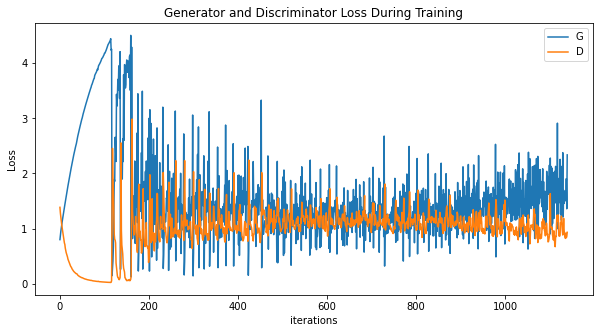

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

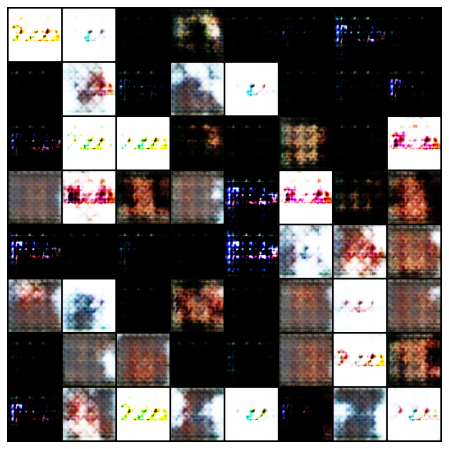

In [15]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.

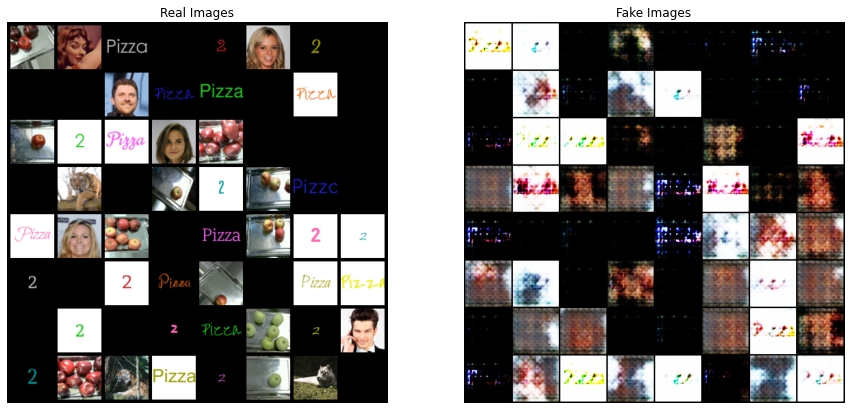

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()